In [13]:
# Project Name - AutoML and Hyperparameter Optimization System.

In [14]:
# Step 1 - Install Libraries

!pip install optuna lightgbm xgboost seaborn

In [15]:
# Step 2 - Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
import optuna

In [16]:
# Step 3 - Upload Dataset

from google.colab import files
uploaded = files.upload()
import zipfile, io, os
if any(name.endswith('.zip') for name in uploaded.keys()):
    with zipfile.ZipFile(io.BytesIO(list(uploaded.values())[0]), 'r') as z:
        z.extractall()
        print("Extracted files:", z.namelist())
# Load CSV files
train_df = pd.read_csv("Dataset/Train.csv")
test_df = pd.read_csv("Dataset/Test.csv")
gender_df = pd.read_csv("Dataset/Gender Submission.csv")
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Saving Dataset.zip to Dataset.zip
Extracted files: ['Dataset/', 'Dataset/Gender Submission.csv', 'Dataset/Test.csv', 'Dataset/Train.csv']
Train shape: (891, 12)
Test shape: (418, 11)


In [25]:
# Step 4 - Data Preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
def preprocess_data(train_df, test_df):
    train = train_df.copy()
    test = test_df.copy()
    # Fill missing values
    for df in [train, test]:
        df['Age'] = df['Age'].fillna(df['Age'].median())
        df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
        if "Fare" in df.columns:
            df['Fare'] = df['Fare'].fillna(df['Fare'].median())
        # Feature Engineering
        df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
        df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
        # Use raw string for regex
        df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
        # Map similar titles into categories
        df['Title'] = df['Title'].replace(['Mlle','Ms'], 'Miss')
        df['Title'] = df['Title'].replace(['Mme'], 'Mrs')
        df['Title'] = df['Title'].replace(
            ['Don','Rev','Dr','Major','Lady','Sir','Col','Capt','Countess','Jonkheer','Dona'],
            'Rare'
        )
    # Drop unused columns
    drop_cols = ['PassengerId','Name','Ticket','Cabin']
    train = train.drop(columns=drop_cols, errors='ignore')
    test = test.drop(columns=drop_cols, errors='ignore')
    # Encode categorical features using combined data
    cat_cols = ['Sex','Embarked','Title']
    combined = pd.concat([train[cat_cols], test[cat_cols]], axis=0)
    encoders = {}
    for col in cat_cols:
        le = LabelEncoder()
        le.fit(combined[col])
        train[col] = le.transform(train[col])
        test[col] = le.transform(test[col])
        encoders[col] = le
    return train, test, encoders
# Apply preprocessing
train, test, encoders = preprocess_data(train_df, test_df)
X = train.drop("Survived", axis=1)
y = train["Survived"]
print("Processed features:", X.shape)
# Define features and target
X = train.drop("Survived", axis=1)
y = train["Survived"]
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Shapes ->", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
X.head(20)

Processed features: (891, 10)
Shapes -> (712, 10) (179, 10) (712,) (179,)


Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  FamilySize  IsAlone  \
0        3    1  22.0      1      0   7.2500         2           2        0   
1        1    0  38.0      1      0  71.2833         0           2        0   
2        3    0  26.0      0      0   7.9250         2           1        1   
3        1    0  35.0      1      0  53.1000         2           2        0   
4        3    1  35.0      0      0   8.0500         2           1        1   
5        3    1  28.0      0      0   8.4583         1           1        1   
6        1    1  54.0      0      0  51.8625         2           1        1   
7        3    1   2.0      3      1  21.0750         2           5        0   
8        3    0  27.0      0      2  11.1333         2           3        0   
9        2    0  14.0      1      0  30.0708         0           2        0   
10       3    0   4.0      1      1  16.7000         2           3        0   
11       1    0  58.0      0      0  26.5500         2           1        1   
12       3    1  20.0      0      0   8.0500         2           1        1   
13       3    1  39.0      1      5  31.2750         2           7        0   
14       3    0  14.0      0      0   7.8542         2           1        1   
15       2    0  55.0      0      0  16.0000         2           1        1   
16       3    1   2.0      4      1  29.1250         1           6        0   
17       2    1  28.0      0      0  13.0000         2           1        1   
18       3    0  31.0      1      0  18.0000         2           2        0   
19       3    0  28.0      0      0   7.2250         0           1        1   

    Title  
0       2  
1       3  
2       1  
3       3  
4       2  
5       2  
6       2  
7       0  
8       3  
9       3  
10      1  
11      1  
12      2  
13      2  
14      1  
15      3  
16      0  
17      2  
18      3  
19      3

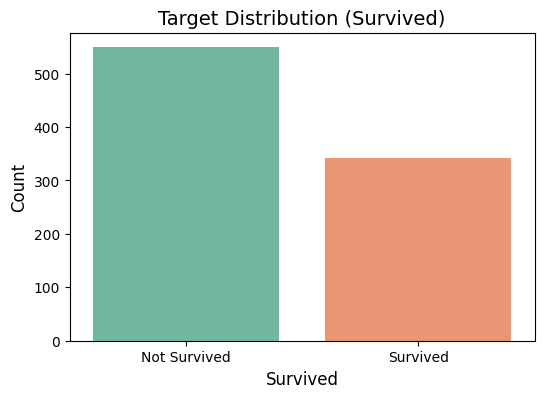

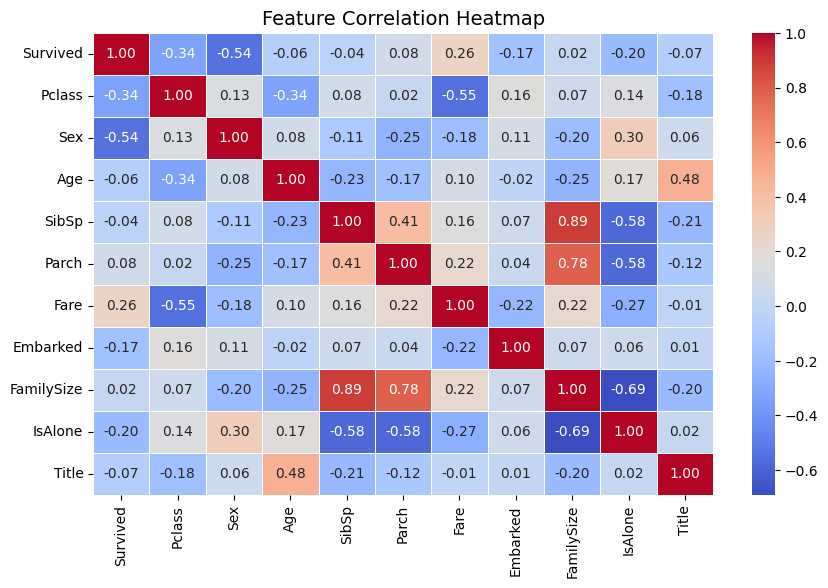

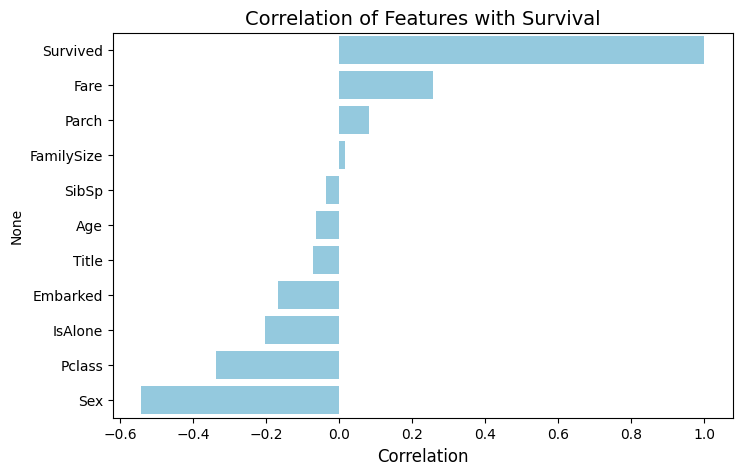

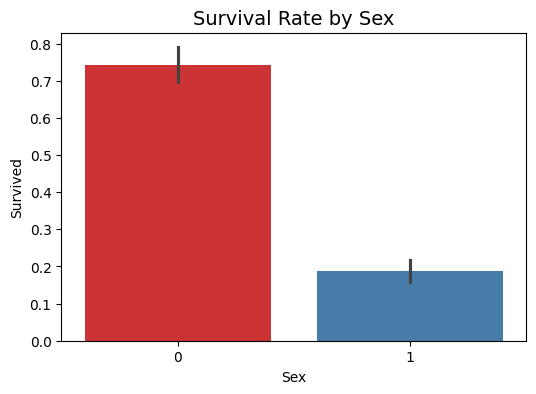

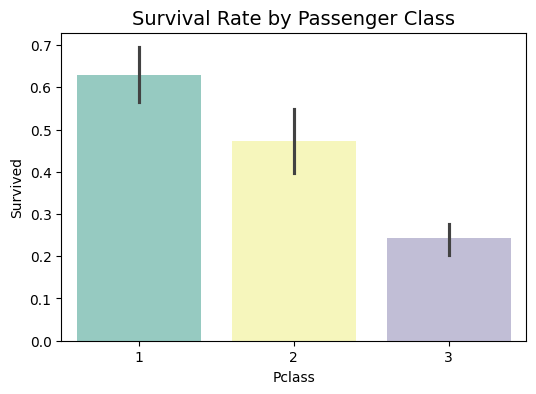

In [26]:
# Step 5  - EDA & Visualizations

# Target distribution
plt.figure(figsize=(6,4))
sns.countplot(x=y, hue=y, palette="Set2", legend=False)
plt.title("Target Distribution (Survived)", fontsize=14)
plt.xlabel("Survived", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0,1], ["Not Survived", "Survived"])
plt.show()
# Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=14)
plt.show()
# Correlation of features with target
corr_with_target = train.corr(numeric_only=True)["Survived"].sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=corr_with_target.values,
            y=corr_with_target.index,
            color="skyblue")
plt.title("Correlation of Features with Survival", fontsize=14)
plt.xlabel("Correlation", fontsize=12)
plt.show()
# Categorical comparisons
plt.figure(figsize=(6,4))
sns.barplot(x="Sex", y="Survived", data=train, hue="Sex", palette="Set1", legend=False)
plt.title("Survival Rate by Sex", fontsize=14)
plt.show()
plt.figure(figsize=(6,4))
sns.barplot(x="Pclass", y="Survived", data=train, hue="Pclass", palette="Set3", legend=False)
plt.title("Survival Rate by Passenger Class", fontsize=14)
plt.show()

In [29]:
# Step 6 - Baseline Models

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import xgboost as xgb
import lightgbm as lgb
# Train-Test Split
X = train.drop("Survived", axis=1)
y = train["Survived"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Define Baseline Models
baseline_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": xgb.XGBClassifier(eval_metric="logloss", random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}
print("===== Baseline Model Performance =====")
baseline_results = {}
for name, model in baseline_models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    score = model.score(X_test, y_test)
    baseline_results[name] = score
    print(f"\n{name} Performance:")
    print(classification_report(y_test, preds))
# Show Model Accuracies
print("\n===== Baseline Model Accuracy Summary =====")
for name, acc in baseline_results.items():
    print(f"{name}: {acc:.4f}")

===== Baseline Model Performance =====

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       110
           1       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       110
           1       0.76      0.75      0.76        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179


SVM Performance:
              precision    recall  f1-score   support

           0       0.64      0.87      0.74       110
           1       0.53      0.23      0.32        69

    accuracy                           0.63       179
   macro 

In [31]:
# Step 7 - Hyperparameter Optimization

# Logistic Regression (Grid Search)
param_grid_lr = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs", "liblinear"]
}
grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid_lr,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
grid_lr.fit(X_train, y_train)
# Random Forest (Random Search)
param_dist_rf = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [None, 5, 10, 15],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
rand_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_dist_rf,
    n_iter=20,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)
rand_rf.fit(X_train, y_train)
# SVM (Grid Search)
param_grid_svm = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}
grid_svm = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid_svm,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)
grid_svm.fit(X_train, y_train)
# XGBoost (Optuna)
def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "random_state": 42,
        "eval_metric": "logloss"  # keeps it clean, no warnings
    }
    model = xgb.XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    return scores.mean()
study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=50)
# LightGBM (Optuna)
def objective_lgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", -1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "random_state": 42
    }
    model = lgb.LGBMClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy")
    return scores.mean()
study_lgb = optuna.create_study(direction="maximize")
study_lgb.optimize(objective_lgb, n_trials=50)

[I 2025-09-02 08:43:06,376] A new study created in memory with name: no-name-05bc24bb-029f-4676-8d05-810e9f4a275f
[I 2025-09-02 08:43:06,759] Trial 0 finished with value: 0.8006500541711808 and parameters: {'n_estimators': 146, 'max_depth': 10, 'learning_rate': 0.19776761837986012, 'subsample': 0.7449018078636211, 'colsample_bytree': 0.9914240952893643}. Best is trial 0 with value: 0.8006500541711808.
[I 2025-09-02 08:43:07,450] Trial 1 finished with value: 0.7978528513739782 and parameters: {'n_estimators': 499, 'max_depth': 4, 'learning_rate': 0.18174602610275278, 'subsample': 0.9237996557901014, 'colsample_bytree': 0.5219659796038111}. Best is trial 0 with value: 0.8006500541711808.
[I 2025-09-02 08:43:08,230] Trial 2 finished with value: 0.7753373387176203 and parameters: {'n_estimators': 489, 'max_depth': 5, 'learning_rate': 0.25777562208512905, 'subsample': 0.7808844924790204, 'colsample_bytree': 0.8522667158570807}. Best is trial 0 with value: 0.8006500541711808.
[I 2025-09-02 0

[LightGBM] [Info] Number of positive: 218, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383128 -> initscore=-0.476291
[LightGBM] [Info] Start training from score -0.476291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:44,470] Trial 0 finished with value: 0.800640204865557 and parameters: {'n_estimators': 136, 'max_depth': 9, 'learning_rate': 0.16466044485015255, 'num_leaves': 93, 'subsample': 0.9384401372265481, 'colsample_bytree': 0.7990092234390863}. Best is trial 0 with value: 0.800640204865557.
[I 2025-09-02 08:43:44,672] Trial 1 finished with value: 0.7936176499556782 and parameters: {'n_estimators': 136, 'max_depth': 6, 'learning_rate': 0.25863503026356605, 'num_leaves': 46, 'subsample': 0.7198088080338798, 'colsample_bytree': 0.7303710726760714}. Best is trial 0 with value: 0.800640204865557.


[LightGBM] [Info] Number of positive: 218, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383128 -> initscore=-0.476291
[LightGBM] [Info] Start training from score -0.476291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:44,771] Trial 2 finished with value: 0.8189106667979906 and parameters: {'n_estimators': 115, 'max_depth': 1, 'learning_rate': 0.08407131977177697, 'num_leaves': 86, 'subsample': 0.7158858769763724, 'colsample_bytree': 0.6687028207440822}. Best is trial 2 with value: 0.8189106667979906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:44,951] Trial 3 finished with value: 0.807662759775436 and parameters: {'n_estimators': 306, 'max_depth': 1, 'learning_rate': 0.11977288051600028, 'num_leaves': 40, 'subsample': 0.9609507840495549, 'colsample_bytree': 0.8229380799263735}. Best is trial 2 with value: 0.8189106667979906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:45,629] Trial 4 finished with value: 0.8048754062838569 and parameters: {'n_estimators': 434, 'max_depth': 10, 'learning_rate': 0.03472339947962984, 'num_leaves': 29, 'subsample': 0.536087765135831, 'colsample_bytree': 0.7604764559823858}. Best is trial 2 with value: 0.8189106667979906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:46,233] Trial 5 finished with value: 0.7795725401359204 and parameters: {'n_estimators': 402, 'max_depth': 9, 'learning_rate': 0.2765906151649457, 'num_leaves': 34, 'subsample': 0.8679415598428807, 'colsample_bytree': 0.7176469237247128}. Best is trial 2 with value: 0.8189106667979906.


[LightGBM] [Info] Number of positive: 219, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 570, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384211 -> initscore=-0.471714
[LightGBM] [Info] Start training from score -0.471714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:46,886] Trial 6 finished with value: 0.789392297843002 and parameters: {'n_estimators': 277, 'max_depth': 10, 'learning_rate': 0.2902777779644034, 'num_leaves': 25, 'subsample': 0.7437015629270791, 'colsample_bytree': 0.7113918905314909}. Best is trial 2 with value: 0.8189106667979906.


[LightGBM] [Info] Number of positive: 219, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 570, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384211 -> initscore=-0.471714
[LightGBM] [Info] Start training from score -0.471714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:48,210] Trial 7 finished with value: 0.785196493647198 and parameters: {'n_estimators': 430, 'max_depth': 0, 'learning_rate': 0.1300989255533769, 'num_leaves': 65, 'subsample': 0.9475700683188004, 'colsample_bytree': 0.8848074271806634}. Best is trial 2 with value: 0.8189106667979906.
[I 2025-09-02 08:43:48,393] Trial 8 finished with value: 0.8104895104895105 and parameters: {'n_estimators': 149, 'max_depth': 2, 'learning_rate': 0.10993946632252875, 'num_leaves': 57, 'subsample': 0.5758389541295756, 'colsample_bytree': 0.5967431619703571}. Best is trial 2 with value: 0.8189106667979906.


[LightGBM] [Info] Number of positive: 218, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383128 -> initscore=-0.476291
[LightGBM] [Info] Start training from score -0.476291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:48,768] Trial 9 finished with value: 0.804855707672609 and parameters: {'n_estimators': 120, 'max_depth': 10, 'learning_rate': 0.13773535462020647, 'num_leaves': 68, 'subsample': 0.5991494642474073, 'colsample_bytree': 0.5561256881247256}. Best is trial 2 with value: 0.8189106667979906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:49,221] Trial 10 finished with value: 0.8146951639909386 and parameters: {'n_estimators': 234, 'max_depth': 4, 'learning_rate': 0.010817194094859955, 'num_leaves': 100, 'subsample': 0.680078803271396, 'colsample_bytree': 0.6260661024432157}. Best is trial 2 with value: 0.8189106667979906.


[LightGBM] [Info] Number of positive: 219, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 570, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384211 -> initscore=-0.471714
[LightGBM] [Info] Start training from score -0.471714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:49,638] Trial 11 finished with value: 0.8090613611740374 and parameters: {'n_estimators': 231, 'max_depth': 4, 'learning_rate': 0.016603835639833017, 'num_leaves': 100, 'subsample': 0.669955561127659, 'colsample_bytree': 0.6262448987012555}. Best is trial 2 with value: 0.8189106667979906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:49,930] Trial 12 finished with value: 0.8146754653796908 and parameters: {'n_estimators': 220, 'max_depth': 4, 'learning_rate': 0.06315054289539813, 'num_leaves': 84, 'subsample': 0.8390391921726504, 'colsample_bytree': 0.6495928834713958}. Best is trial 2 with value: 0.8189106667979906.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:50,548] Trial 13 finished with value: 0.7922387471683247 and parameters: {'n_estimators': 343, 'max_depth': -1, 'learning_rate': 0.06731587990622984, 'num_leaves': 81, 'subsample': 0.6521391541848441, 'colsample_bytree': 0.9826037995698399}. Best is trial 2 with value: 0.8189106667979906.
[I 2025-09-02 08:43:50,736] Trial 14 finished with value: 0.8231261696050428 and parameters: {'n_estimators': 215, 'max_depth': 2, 'learning_rate': 0.18027138182656474, 'num_leaves': 81, 'subsample': 0.8108184289094713, 'colsample_bytree': 0.5179335340993227}. Best is trial 14 with value: 0.8231261696050428.


[LightGBM] [Info] Number of positive: 218, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383128 -> initscore=-0.476291
[LightGBM] [Info] Start training from score -0.476291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:50,937] Trial 15 finished with value: 0.8231360189106669 and parameters: {'n_estimators': 188, 'max_depth': 2, 'learning_rate': 0.20502817321652583, 'num_leaves': 77, 'subsample': 0.8281919065039354, 'colsample_bytree': 0.5489551954300699}. Best is trial 15 with value: 0.8231360189106669.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:51,586] Trial 16 finished with value: 0.7837486457204766 and parameters: {'n_estimators': 498, 'max_depth': 6, 'learning_rate': 0.2031425904543819, 'num_leaves': 74, 'subsample': 0.8161054236232109, 'colsample_bytree': 0.5089284536753617}. Best is trial 15 with value: 0.8231360189106669.


[LightGBM] [Info] Number of positive: 219, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 570, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384211 -> initscore=-0.471714
[LightGBM] [Info] Start training from score -0.471714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:51,779] Trial 17 finished with value: 0.8217177189008176 and parameters: {'n_estimators': 185, 'max_depth': 2, 'learning_rate': 0.21473546472497818, 'num_leaves': 53, 'subsample': 0.8060181116169317, 'colsample_bytree': 0.5073313924524583}. Best is trial 15 with value: 0.8231360189106669.


[LightGBM] [Info] Number of positive: 218, number of negative: 352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 570, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382456 -> initscore=-0.479136
[LightGBM] [Info] Start training from score -0.479136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:52,078] Trial 18 finished with value: 0.8048261597557372 and parameters: {'n_estimators': 186, 'max_depth': 6, 'learning_rate': 0.1917798295432609, 'num_leaves': 72, 'subsample': 0.8769084460130624, 'colsample_bytree': 0.5601410622780645}. Best is trial 15 with value: 0.8231360189106669.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:52,382] Trial 19 finished with value: 0.8048458583669852 and parameters: {'n_estimators': 280, 'max_depth': 3, 'learning_rate': 0.23436703772600326, 'num_leaves': 77, 'subsample': 0.9988414134188695, 'colsample_bytree': 0.5475388362960306}. Best is trial 15 with value: 0.8231360189106669.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:52,729] Trial 20 finished with value: 0.8020388062641585 and parameters: {'n_estimators': 184, 'max_depth': -1, 'learning_rate': 0.1630730969308028, 'num_leaves': 90, 'subsample': 0.8960827449300757, 'colsample_bytree': 0.590680877045747}. Best is trial 15 with value: 0.8231360189106669.


[LightGBM] [Info] Number of positive: 218, number of negative: 352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 570, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382456 -> initscore=-0.479136
[LightGBM] [Info] Start training from score -0.479136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:52,914] Trial 21 finished with value: 0.8216881709839455 and parameters: {'n_estimators': 186, 'max_depth': 2, 'learning_rate': 0.2135073669564755, 'num_leaves': 58, 'subsample': 0.7904697330776613, 'colsample_bytree': 0.508702105642803}. Best is trial 15 with value: 0.8231360189106669.


[LightGBM] [Info] Number of positive: 218, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383128 -> initscore=-0.476291
[LightGBM] [Info] Start training from score -0.476291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:53,153] Trial 22 finished with value: 0.8174825174825175 and parameters: {'n_estimators': 251, 'max_depth': 2, 'learning_rate': 0.2405161715996207, 'num_leaves': 48, 'subsample': 0.7840303120093469, 'colsample_bytree': 0.5021736642186042}. Best is trial 15 with value: 0.8231360189106669.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:53,320] Trial 23 finished with value: 0.8062543090712104 and parameters: {'n_estimators': 170, 'max_depth': 1, 'learning_rate': 0.18896952534546357, 'num_leaves': 53, 'subsample': 0.7676281970093749, 'colsample_bytree': 0.5609568318818906}. Best is trial 15 with value: 0.8231360189106669.


[LightGBM] [Info] Number of positive: 218, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383128 -> initscore=-0.476291
[LightGBM] [Info] Start training from score -0.476291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:53,552] Trial 24 finished with value: 0.8147148626021865 and parameters: {'n_estimators': 210, 'max_depth': 3, 'learning_rate': 0.22351937054612153, 'num_leaves': 66, 'subsample': 0.8366150228673157, 'colsample_bytree': 0.5384853963665391}. Best is trial 15 with value: 0.8231360189106669.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:54,174] Trial 25 finished with value: 0.7823500443218754 and parameters: {'n_estimators': 339, 'max_depth': 0, 'learning_rate': 0.17660086556454557, 'num_leaves': 79, 'subsample': 0.8104000639790566, 'colsample_bytree': 0.5972902257231975}. Best is trial 15 with value: 0.8231360189106669.


[LightGBM] [Info] Number of positive: 219, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 570, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384211 -> initscore=-0.471714
[LightGBM] [Info] Start training from score -0.471714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:54,558] Trial 26 finished with value: 0.7936078006500541 and parameters: {'n_estimators': 261, 'max_depth': 5, 'learning_rate': 0.24886999800328274, 'num_leaves': 62, 'subsample': 0.9094447142290619, 'colsample_bytree': 0.6784953757855701}. Best is trial 15 with value: 0.8231360189106669.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:54,794] Trial 27 finished with value: 0.8188909681867429 and parameters: {'n_estimators': 207, 'max_depth': 3, 'learning_rate': 0.14745491692407733, 'num_leaves': 71, 'subsample': 0.7406114052870693, 'colsample_bytree': 0.5229857131048149}. Best is trial 15 with value: 0.8231360189106669.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:55,168] Trial 28 finished with value: 0.7922190485570767 and parameters: {'n_estimators': 165, 'max_depth': 0, 'learning_rate': 0.20853865340722258, 'num_leaves': 93, 'subsample': 0.8547008959723247, 'colsample_bytree': 0.5894676503468788}. Best is trial 15 with value: 0.8231360189106669.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:55,418] Trial 29 finished with value: 0.8161036146951639 and parameters: {'n_estimators': 155, 'max_depth': 5, 'learning_rate': 0.16889402497247194, 'num_leaves': 52, 'subsample': 0.9143411407944699, 'colsample_bytree': 0.8384896703335161}. Best is trial 15 with value: 0.8231360189106669.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:55,641] Trial 30 finished with value: 0.797852851373978 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.26732443592160904, 'num_leaves': 92, 'subsample': 0.8171501665488616, 'colsample_bytree': 0.9310434750172574}. Best is trial 15 with value: 0.8231360189106669.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:55,846] Trial 31 finished with value: 0.8217078695951937 and parameters: {'n_estimators': 199, 'max_depth': 2, 'learning_rate': 0.2142205034595128, 'num_leaves': 60, 'subsample': 0.785237225258908, 'colsample_bytree': 0.5036011421931929}. Best is trial 15 with value: 0.8231360189106669.


[LightGBM] [Info] Number of positive: 218, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383128 -> initscore=-0.476291
[LightGBM] [Info] Start training from score -0.476291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:56,051] Trial 32 finished with value: 0.8273416724120949 and parameters: {'n_estimators': 194, 'max_depth': 2, 'learning_rate': 0.18550186897286797, 'num_leaves': 42, 'subsample': 0.714516290828718, 'colsample_bytree': 0.524862666317178}. Best is trial 32 with value: 0.8273416724120949.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:56,229] Trial 33 finished with value: 0.8090515118684131 and parameters: {'n_estimators': 134, 'max_depth': 1, 'learning_rate': 0.18491153478833794, 'num_leaves': 41, 'subsample': 0.7063689733643919, 'colsample_bytree': 0.5700102710887565}. Best is trial 32 with value: 0.8273416724120949.


[LightGBM] [Info] Number of positive: 218, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383128 -> initscore=-0.476291
[LightGBM] [Info] Start training from score -0.476291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:56,531] Trial 34 finished with value: 0.8146656160740668 and parameters: {'n_estimators': 307, 'max_depth': 3, 'learning_rate': 0.15512309893533055, 'num_leaves': 41, 'subsample': 0.6346791198871378, 'colsample_bytree': 0.5357207188362609}. Best is trial 32 with value: 0.8273416724120949.
[I 2025-09-02 08:43:56,735] Trial 35 finished with value: 0.8146656160740667 and parameters: {'n_estimators': 243, 'max_depth': 1, 'learning_rate': 0.22641398881003172, 'num_leaves': 47, 'subsample': 0.7066388866089219, 'colsample_bytree': 0.6459325922330543}. Best is trial 32 with value: 0.8273416724120949.


[LightGBM] [Info] Number of positive: 218, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383128 -> initscore=-0.476291
[LightGBM] [Info] Start training from score -0.476291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:56,903] Trial 36 finished with value: 0.8217078695951935 and parameters: {'n_estimators': 123, 'max_depth': 2, 'learning_rate': 0.19721484909046172, 'num_leaves': 34, 'subsample': 0.7551506977769963, 'colsample_bytree': 0.7823693736040546}. Best is trial 32 with value: 0.8273416724120949.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:57,071] Trial 37 finished with value: 0.8062543090712104 and parameters: {'n_estimators': 148, 'max_depth': 1, 'learning_rate': 0.10585515449215388, 'num_leaves': 35, 'subsample': 0.7169977405737487, 'colsample_bytree': 0.6143918183761659}. Best is trial 32 with value: 0.8273416724120949.


[LightGBM] [Info] Number of positive: 218, number of negative: 352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 570, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382456 -> initscore=-0.479136
[LightGBM] [Info] Start training from score -0.479136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:57,580] Trial 38 finished with value: 0.7922387471683247 and parameters: {'n_estimators': 280, 'max_depth': 0, 'learning_rate': 0.2538991716823922, 'num_leaves': 20, 'subsample': 0.50511014511102, 'colsample_bytree': 0.6910310480125625}. Best is trial 32 with value: 0.8273416724120949.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:57,795] Trial 39 finished with value: 0.8202895695853443 and parameters: {'n_estimators': 173, 'max_depth': 3, 'learning_rate': 0.17829822494663, 'num_leaves': 88, 'subsample': 0.8648745767029811, 'colsample_bytree': 0.5754202402876405}. Best is trial 32 with value: 0.8273416724120949.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:58,208] Trial 40 finished with value: 0.7908105978528515 and parameters: {'n_estimators': 201, 'max_depth': 7, 'learning_rate': 0.29789802647618313, 'num_leaves': 54, 'subsample': 0.7399990061657101, 'colsample_bytree': 0.7480217883654854}. Best is trial 32 with value: 0.8273416724120949.


[LightGBM] [Info] Number of positive: 219, number of negative: 351
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 570, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384211 -> initscore=-0.471714
[LightGBM] [Info] Start training from score -0.471714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-09-02 08:43:58,419] Trial 41 finished with value: 0.8174825174825175 and parameters: {'n_estimators': 206, 'max_depth': 2, 'learning_rate': 0.21286374624407062, 'num_leaves': 45, 'subsample': 0.7894727076199837, 'colsample_bytree': 0.5220306288198961}. Best is trial 32 with value: 0.8273416724120949.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:58,652] Trial 42 finished with value: 0.8188909681867429 and parameters: {'n_estimators': 224, 'max_depth': 2, 'learning_rate': 0.21707104294685325, 'num_leaves': 62, 'subsample': 0.7658507897609801, 'colsample_bytree': 0.5004694770492166}. Best is trial 32 with value: 0.8273416724120949.


[LightGBM] [Info] Number of positive: 218, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383128 -> initscore=-0.476291
[LightGBM] [Info] Start training from score -0.476291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:58,889] Trial 43 finished with value: 0.8203092681965922 and parameters: {'n_estimators': 190, 'max_depth': 3, 'learning_rate': 0.23907223492280358, 'num_leaves': 49, 'subsample': 0.7996402464354765, 'colsample_bytree': 0.5376087516741455}. Best is trial 32 with value: 0.8273416724120949.


[LightGBM] [Info] Number of positive: 218, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383128 -> initscore=-0.476291
[LightGBM] [Info] Start training from score -0.476291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:59,266] Trial 44 finished with value: 0.811878262582488 and parameters: {'n_estimators': 261, 'max_depth': 4, 'learning_rate': 0.1446480792047249, 'num_leaves': 84, 'subsample': 0.8239937240853416, 'colsample_bytree': 0.5252167054705725}. Best is trial 32 with value: 0.8273416724120949.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:43:59,637] Trial 45 finished with value: 0.7795823894415443 and parameters: {'n_estimators': 155, 'max_depth': 0, 'learning_rate': 0.2788515723833403, 'num_leaves': 76, 'subsample': 0.693256973150494, 'colsample_bytree': 0.5510751644888994}. Best is trial 32 with value: 0.8273416724120949.


[LightGBM] [Info] Number of positive: 219, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 570, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.384211 -> initscore=-0.471714
[LightGBM] [Info] Start training from score -0.471714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:43:59,889] Trial 46 finished with value: 0.8132670146754654 and parameters: {'n_estimators': 225, 'max_depth': 1, 'learning_rate': 0.20093580150108117, 'num_leaves': 69, 'subsample': 0.732781694360608, 'colsample_bytree': 0.6189921157939954}. Best is trial 32 with value: 0.8273416724120949.


[LightGBM] [Info] Number of positive: 218, number of negative: 352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 570, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.382456 -> initscore=-0.479136
[LightGBM] [Info] Start training from score -0.479136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:44:00,072] Trial 47 finished with value: 0.8104796611838865 and parameters: {'n_estimators': 101, 'max_depth': 2, 'learning_rate': 0.12207104846880854, 'num_leaves': 30, 'subsample': 0.7721103782186263, 'colsample_bytree': 0.578755715523868}. Best is trial 32 with value: 0.8273416724120949.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-09-02 08:44:00,383] Trial 48 finished with value: 0.8203092681965922 and parameters: {'n_estimators': 138, 'max_depth': 4, 'learning_rate': 0.17059667041086612, 'num_leaves': 97, 'subsample': 0.8459581198729134, 'colsample_bytree': 0.5242072623548534}. Best is trial 32 with value: 0.8273416724120949.


[LightGBM] [Info] Number of positive: 218, number of negative: 351
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383128 -> initscore=-0.476291
[LightGBM] [Info] Start training from score -0.476291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-09-02 08:44:00,721] Trial 49 finished with value: 0.8104501132670148 and parameters: {'n_estimators': 327, 'max_depth': 1, 'learning_rate': 0.1603076061024168, 'num_leaves': 38, 'subsample': 0.6247776598494931, 'colsample_bytree': 0.5533799884583701}. Best is trial 32 with value: 0.8273416724120949.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [32]:
# Step 8 - Final Model Selection
final_results = {
    "Logistic Regression": grid_lr.best_score_,
    "Random Forest": rand_rf.best_score_,
    "SVM": grid_svm.best_score_,
    "XGBoost": study_xgb.best_value,
    "LightGBM": study_lgb.best_value
}
print("\n===== Final Comparison (CV Accuracy) =====")
for model_name, score in final_results.items():
    print(f"{model_name}: {score:.4f}")
best_model_name = max(final_results, key=final_results.get)
print(f"\n✅ Best Model Selected: {best_model_name} "
      f"with Accuracy = {final_results[best_model_name]:.4f}")


===== Final Comparison (CV Accuracy) =====
Logistic Regression: 0.8035
Random Forest: 0.8245
SVM: 0.7908
XGBoost: 0.8245
LightGBM: 0.8273

✅ Best Model Selected: LightGBM with Accuracy = 0.8273
